# NLP con Long-Short Term Memory (LSTM)

## Autores 

### *  Yasmin Johanna Garcia 
### *  Javier Ricardo Muñoz

### Preparación de paquetes 

In [ ]:
!pip install torch torchtext torchvision torchaudio
!pip install transformers
!pip install datasets
!pip install scikit-learn
!pip install matplotlib seaborn
!pip install --upgrade datasets huggingface_hub
!pip install imbalanced-learn]

# Cargar y explorar el dataset


# El dataset PAWS-X (Paraphrase Adversaries from Word Scrambling en su versión multilingüe) 

Corresponde a un conjunto de pares de oraciones diseñadas para evaluar la capacidad de los modelos de lenguaje en tareas de detección de paráfrasis. En particular, el subconjunto en español contiene frases que son muy similares en estructura y vocabulario, pero que no siempre tienen el mismo significado. Cada ejemplo consta de dos oraciones (sentence1 y sentence2) y una etiqueta binaria (label) que indica si ambas expresan la misma idea (1) o si, por el contrario, son diferentes (0). Este dataset es un reto interesante porque exige que el modelo capture matices semánticos sutiles y no se quede únicamente en la coincidencia superficial de palabras.

In [3]:
#Llamamos el dataset

from datasets import load_dataset
ds = load_dataset("paws-x", "es")
print(ds["train"][0])


c:\Users\yasmi\anaconda\envs\torch_gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{'id': 1, 'sentence1': 'En París, en octubre de 1560, se reunió en secreto con el embajador inglés, Nicolas Throckmorton, pidiéndole un pasaporte para regresar a Inglaterra a través de Escocia.', 'sentence2': 'En octubre de 1560, se reunió en secreto con el embajador inglés, Nicolas Throckmorton, en París, y le pidió un pasaporte para regresar a Escocia a través de Inglaterra.', 'label': 0}


In [4]:
# Ver las columnas
print(ds["train"].features)

# Ejemplo de la primera fila
print(ds["train"][0])

{'id': Value('int32'), 'sentence1': Value('string'), 'sentence2': Value('string'), 'label': ClassLabel(names=['0', '1'])}
{'id': 1, 'sentence1': 'En París, en octubre de 1560, se reunió en secreto con el embajador inglés, Nicolas Throckmorton, pidiéndole un pasaporte para regresar a Inglaterra a través de Escocia.', 'sentence2': 'En octubre de 1560, se reunió en secreto con el embajador inglés, Nicolas Throckmorton, en París, y le pidió un pasaporte para regresar a Escocia a través de Inglaterra.', 'label': 0}


In [5]:
ds["train"].to_pandas().head(8)

,id,sentence1,sentence2,label
0,1,"En París, en octubre de 1560, se reunió en sec...","En octubre de 1560, se reunió en secreto con e...",0
1,2,La temporada de la NBA de 1975: 76 fue la 30ª ...,La temporada 1975 - 76 de la Asociación Nacion...,1
2,3,"También hay discusiones específicas, debates d...","También hay discusiones públicas, discusiones ...",0
3,4,Cuando se pueden mantener tasas de flujo compa...,Los resultados son altos cuando se pueden mant...,1
4,5,Es la sede del distrito de Zerendi en la regió...,Es la sede del distrito de Zerendi en la regió...,1
5,6,William Henry Henry Harman nació el 17 de febr...,"William Henry Harman nació en Waynesboro, Virg...",1
6,7,Bullion Express: el concepto se está introduci...,2011-Se presenta el concepto DGSE Bullion Expr...,0
7,8,Con una cantidad discreta de probabilidades Fó...,"Dado un conjunto discreto de probabilidades, l...",1


# Preprocesamiento y tokenización

In [10]:
from transformers import AutoTokenizer

# Tokenizador multilingüe (incluye español)
tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")


In [11]:
def tokenize_function(examples):
    return tokenizer(
        examples["sentence1"],
        examples["sentence2"],   # usamos ambas frases
        padding="max_length",    # rellenamos hasta max_length
        truncation=True,
        max_length=64            # frases cortas → con 64 tokens basta
    )


In [12]:
tokenized_ds = ds.map(tokenize_function, batched=True)
tokenized_ds



DatasetDict({
    train: Dataset({
        features: ['id', 'sentence1', 'sentence2', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 49401
    })
    test: Dataset({
        features: ['id', 'sentence1', 'sentence2', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2000
    })
    validation: Dataset({
        features: ['id', 'sentence1', 'sentence2', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2000
    })
})

In [14]:
import torch
ejemplo = tokenized_ds["train"][0]

for k, v in ejemplo.items():
    if isinstance(v, torch.Tensor):
        print(f"{k}: shape={v.shape}, dtype={v.dtype}")
    else:
        print(f"{k}: {v if len(str(v)) < 80 else str(v)[:80] + '...'}")


id: 1
sentence1: En París, en octubre de 1560, se reunió en secreto con el embajador inglés, Nico...
sentence2: En octubre de 1560, se reunió en secreto con el embajador inglés, Nicolas Throck...
label: 0
input_ids: [101, 10243, 15850, 117, 10110, 14082, 10104, 36995, 117, 10126, 90876, 10110, 6...
token_type_ids: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...
attention_mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1...


In [15]:
# Calcular longitudes de los pares de oraciones concatenados
text_lengths = [len(row["sentence1"] + " " + row["sentence2"]) for row in ds["train"]]

print(f"Texto más corto: {min(text_lengths)}")
print(f"Texto más largo: {max(text_lengths)}")
print(f"Longitud promedio: {sum(text_lengths) / len(text_lengths):.2f}")


Texto más corto: 1
Texto más largo: 525
Longitud promedio: 236.36


## Preparar para Pytorch

In [16]:
import torch
from torch.utils.data import DataLoader

# Formato de tensores
tokenized_ds.set_format(type="torch", columns=["input_ids", "token_type_ids", "attention_mask", "label"])

# Crear DataLoaders
train_loader = DataLoader(tokenized_ds["train"], batch_size=32, shuffle=True)
val_loader = DataLoader(tokenized_ds["validation"], batch_size=32)
test_loader = DataLoader(tokenized_ds["test"], batch_size=32)

# Revisar un batch
batch = next(iter(train_loader))
for k,v in batch.items():
    print(k, v.shape)


label torch.Size([32])
input_ids torch.Size([32, 64])
token_type_ids torch.Size([32, 64])
attention_mask torch.Size([32, 64])


# Definir un modelo LSTM para clasificación

In [17]:
import torch
import torch.nn as nn

class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=128, output_dim=2, n_layers=1, dropout=0.3):
        super(LSTMClassifier, self).__init__()
        
        # Capa de embeddings
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        
        # LSTM
        self.lstm = nn.LSTM(
            input_size=embed_dim,
            hidden_size=hidden_dim,
            num_layers=n_layers,
            batch_first=True,
            dropout=dropout if n_layers > 1 else 0
        )
        
        # Clasificación final
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, input_ids, attention_mask=None, token_type_ids=None):
        # input_ids: [batch, seq_len]
        embedded = self.embedding(input_ids)   # [batch, seq_len, embed_dim]
        lstm_out, (hidden, cell) = self.lstm(embedded)
        
        # Tomamos el último estado oculto
        hidden = hidden[-1]   # [batch, hidden_dim]
        
        # Pasamos por capa fully connected
        output = self.fc(hidden)   # [batch, output_dim]
        return output


El modelo LSTMClassifier está compuesto por tres partes principales:  

1. **Embedding Layer**: convierte los índices de palabras del vocabulario (119,547 tokens) en vectores densos de dimensión 128, permitiendo representar el significado semántico de cada palabra.  
2. **LSTM Layer**: recibe las secuencias de embeddings y captura dependencias temporales/contextuales en ambas direcciones, generando representaciones de las frases que tienen en cuenta el orden y la estructura.  
3. **Fully Connected Layer (Linear)**: toma la última representación oculta del LSTM y la proyecta a dos salidas posibles, correspondientes a las clases del problema (0 = no paráfrasis, 1 = paráfrasis).  

En conjunto, esta arquitectura permite transformar texto en predicciones de clase de manera secuencial, aprovechando la capacidad del LSTM para modelar relaciones entre palabras en oraciones.

In [18]:
vocab_size = tokenizer.vocab_size

model = LSTMClassifier(vocab_size=vocab_size, embed_dim=128, hidden_dim=128, output_dim=2)
print(model)


LSTMClassifier(
  (embedding): Embedding(119547, 128, padding_idx=0)
  (lstm): LSTM(128, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)


# Definir pérdida, optimizador y loop de entrenamiento

In [19]:
import torch
print("CUDA disponible:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Nombre GPU:", torch.cuda.get_device_name(0))
    print("Versión CUDA en PyTorch:", torch.version.cuda)


CUDA disponible: True
Nombre GPU: NVIDIA GeForce RTX 3050 Laptop GPU
Versión CUDA en PyTorch: 12.1


In [20]:
import torch.optim as optim

# Usar GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Entrenando en:", device)

model = model.to(device)

# Función de pérdida
criterion = nn.CrossEntropyLoss()

# Optimizador
optimizer = optim.Adam(model.parameters(), lr=1e-3)


Entrenando en: cuda


## Función de entrenamiento!

In [21]:
def train_epoch(model, data_loader, criterion, optimizer, device):
    model.train()
    total_loss, total_correct = 0, 0
    
    for batch in data_loader:
        input_ids = batch["input_ids"].to(device)
        labels = batch["label"].to(device)
        
        # Forward
        outputs = model(input_ids)
        loss = criterion(outputs, labels)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Métricas
        preds = torch.argmax(outputs, dim=1)
        total_loss += loss.item()
        total_correct += (preds == labels).sum().item()
    
    accuracy = total_correct / len(data_loader.dataset)
    return total_loss / len(data_loader), accuracy


## Función de validación 

In [22]:
def eval_epoch(model, data_loader, criterion, device):
    model.eval()
    total_loss, total_correct = 0, 0
    
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch["input_ids"].to(device)
            labels = batch["label"].to(device)
            
            outputs = model(input_ids)
            loss = criterion(outputs, labels)
            
            preds = torch.argmax(outputs, dim=1)
            total_loss += loss.item()
            total_correct += (preds == labels).sum().item()
    
    accuracy = total_correct / len(data_loader.dataset)
    return total_loss / len(data_loader), accuracy


## Loops de entrenamiento 

In [23]:
EPOCHS = 10

for epoch in range(EPOCHS):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = eval_epoch(model, val_loader, criterion, device)
    
    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"  Train -> Loss: {train_loss:.4f}, Acc: {train_acc:.4f}")
    print(f"  Valid -> Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")


Epoch 1/10
  Train -> Loss: 0.6874, Acc: 0.5571
  Valid -> Loss: 0.6817, Acc: 0.5765
Epoch 2/10
  Train -> Loss: 0.6847, Acc: 0.5628
  Valid -> Loss: 0.6844, Acc: 0.5750
Epoch 3/10
  Train -> Loss: 0.6827, Acc: 0.5720
  Valid -> Loss: 0.6836, Acc: 0.5750
Epoch 4/10
  Train -> Loss: 0.6700, Acc: 0.5890
  Valid -> Loss: 0.6852, Acc: 0.5800
Epoch 5/10
  Train -> Loss: 0.6560, Acc: 0.6035
  Valid -> Loss: 0.6833, Acc: 0.5830
Epoch 6/10
  Train -> Loss: 0.6429, Acc: 0.6151
  Valid -> Loss: 0.6963, Acc: 0.5765
Epoch 7/10
  Train -> Loss: 0.6319, Acc: 0.6263
  Valid -> Loss: 0.6962, Acc: 0.5800
Epoch 8/10
  Train -> Loss: 0.6204, Acc: 0.6367
  Valid -> Loss: 0.7174, Acc: 0.5715
Epoch 9/10
  Train -> Loss: 0.6089, Acc: 0.6465
  Valid -> Loss: 0.7136, Acc: 0.5745
Epoch 10/10
  Train -> Loss: 0.5970, Acc: 0.6560
  Valid -> Loss: 0.7190, Acc: 0.5675


Durante el proceso de entrenamiento del modelo LSTMClassifier se observó una disminución progresiva en la función de pérdida y un aumento sostenido en la exactitud sobre el conjunto de entrenamiento (de 0.55 a 0.65 en 10 épocas), lo cual indica que el modelo logró ajustar sus parámetros y aprender patrones de los datos. Sin embargo, en el conjunto de validación la exactitud se mantuvo prácticamente constante alrededor del 0.57–0.58, mientras que la pérdida tendió a incrementarse a partir de la quinta época. Este comportamiento refleja un fenómeno de sobreajuste, en el cual el modelo mejora su desempeño sobre los datos de entrenamiento pero pierde capacidad de generalización hacia datos no vistos. En consecuencia, aunque se evidencian avances en la fase de aprendizaje, el rendimiento en validación sugiere la necesidad de aplicar técnicas de regularización, como el uso de early stopping, incremento de dropout o el empleo de arquitecturas más robustas, a fin de mejorar la capacidad predictiva y el equilibrio entre entrenamiento y validación.

## Evaluación 

In [ ]:
import sys
!{sys.executable} -m pip install seaborn


In [26]:
import matplotlib.pyplot as plt


In [27]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluación en test set
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Métricas generales
acc = accuracy_score(all_labels, all_preds)
print("Accuracy en test:", acc)
print("\nReporte de clasificación:\n", classification_report(all_labels, all_preds, target_names=["No paráfrasis", "Paráfrasis"]))


Accuracy en test: 0.541

Reporte de clasificación:
                precision    recall  f1-score   support

No paráfrasis       0.55      0.88      0.68      1093
   Paráfrasis       0.48      0.14      0.21       907

     accuracy                           0.54      2000
    macro avg       0.51      0.51      0.44      2000
 weighted avg       0.52      0.54      0.47      2000



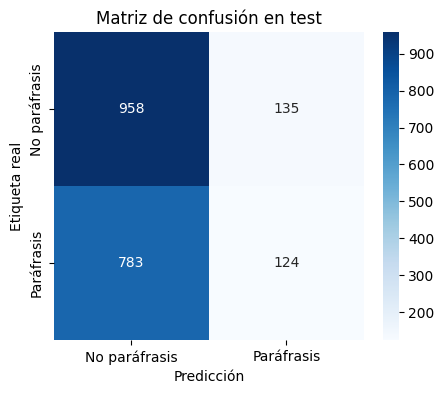

In [30]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No paráfrasis", "Paráfrasis"],
            yticklabels=["No paráfrasis", "Paráfrasis"])
plt.xlabel("Predicción")
plt.ylabel("Etiqueta real")
plt.title("Matriz de confusión en test")
plt.show()


# Interpretación de resultados

El modelo alcanzó una exactitud global del 54% en el conjunto de prueba, valor cercano al obtenido en las fases anteriores y que refleja un rendimiento limitado. 

En el desglose por clases, se observa que el modelo mantiene un buen desempeño en la categoría No paráfrasis, con un recall de 0.88 y un F1-score de 0.68, lo cual indica que identifica la mayoría de los casos negativos. Sin embargo, en la clase Paráfrasis el comportamiento sigue siendo deficiente, con un recall de apenas 0.14 y un F1-score de 0.21, lo que evidencia una baja capacidad para reconocer correctamente los ejemplos positivos. 

El promedio macro de F1 (0.44) confirma el desequilibrio en el desempeño entre ambas clases. En conjunto, los resultados sugieren que, aunque el modelo presenta una tendencia a favorecer la predicción de la clase mayoritaria, persiste la dificultad para discriminar adecuadamente las paráfrasis, por lo que serían necesarias técnicas adicionales de balanceo de clases, mayor regularización o la implementación de modelos preentrenados más sofisticados.

# Mejora del Modelo 

In [31]:
import numpy as np

# Contar clases en train
labels = np.array(ds["train"]["label"])
unique, counts = np.unique(labels, return_counts=True)

print("Distribución de clases:", dict(zip(unique, counts)))


Distribución de clases: {np.int64(0): np.int64(27572), np.int64(1): np.int64(21829)}


### Definir class weights

In [32]:
import torch

# Cantidades de clases
counts = torch.tensor([27572, 21829], dtype=torch.float)

# Pesos inversos a la frecuencia
class_weights = 1.0 / counts
class_weights = class_weights / class_weights.sum()  # normalizar un poco

print("Pesos de clases:", class_weights)

# Pasar a GPU si está disponible
class_weights = class_weights.to(device)

# Redefinir criterio con pesos
criterion = nn.CrossEntropyLoss(weight=class_weights)


Pesos de clases: tensor([0.4419, 0.5581])


In [33]:
## reentrenar el modelo con los nuevos pesos    
EPOCHS = 10
for epoch in range(EPOCHS):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = eval_epoch(model, val_loader, criterion, device)
    
    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"  Train -> Loss: {train_loss:.4f}, Acc: {train_acc:.4f}")
    print(f"  Valid -> Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")


Epoch 1/10
  Train -> Loss: 0.5944, Acc: 0.6586
  Valid -> Loss: 0.7348, Acc: 0.5630
Epoch 2/10
  Train -> Loss: 0.5817, Acc: 0.6669
  Valid -> Loss: 0.7500, Acc: 0.5120
Epoch 3/10
  Train -> Loss: 0.5701, Acc: 0.6737
  Valid -> Loss: 0.8041, Acc: 0.5520
Epoch 4/10
  Train -> Loss: 0.5581, Acc: 0.6838
  Valid -> Loss: 0.8195, Acc: 0.5445
Epoch 5/10
  Train -> Loss: 0.5455, Acc: 0.6912
  Valid -> Loss: 0.8202, Acc: 0.5400
Epoch 6/10
  Train -> Loss: 0.5333, Acc: 0.7007
  Valid -> Loss: 0.8538, Acc: 0.5405
Epoch 7/10
  Train -> Loss: 0.5205, Acc: 0.7089
  Valid -> Loss: 0.8543, Acc: 0.5300
Epoch 8/10
  Train -> Loss: 0.5074, Acc: 0.7156
  Valid -> Loss: 0.9028, Acc: 0.5255
Epoch 9/10
  Train -> Loss: 0.4946, Acc: 0.7247
  Valid -> Loss: 0.9542, Acc: 0.5300
Epoch 10/10
  Train -> Loss: 0.4810, Acc: 0.7341
  Valid -> Loss: 0.9566, Acc: 0.5125


Accuracy en test: 0.508

Reporte de clasificación:
                precision    recall  f1-score   support

No paráfrasis       0.55      0.54      0.55      1093
   Paráfrasis       0.46      0.47      0.46       907

     accuracy                           0.51      2000
    macro avg       0.50      0.50      0.50      2000
 weighted avg       0.51      0.51      0.51      2000



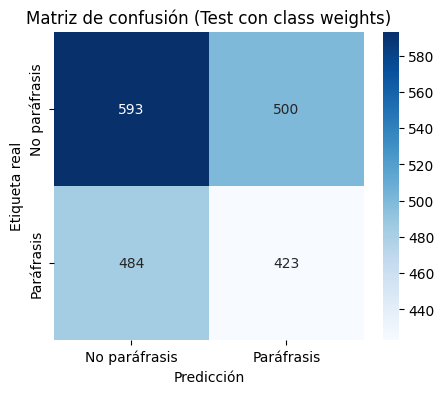

In [34]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# --- Evaluación en test ---
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Métricas generales
acc = accuracy_score(all_labels, all_preds)
print("Accuracy en test:", acc)
print("\nReporte de clasificación:\n", classification_report(all_labels, all_preds, target_names=["No paráfrasis", "Paráfrasis"]))

# --- Matriz de confusión ---
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No paráfrasis", "Paráfrasis"],
            yticklabels=["No paráfrasis", "Paráfrasis"])
plt.xlabel("Predicción")
plt.ylabel("Etiqueta real")
plt.title("Matriz de confusión (Test con class weights)")
plt.show()


## Interpretación de resultados

El modelo obtuvo una exactitud del 50.8% en el conjunto de prueba, lo que indica un rendimiento apenas superior al azar en un problema binario. A diferencia de ejecuciones previas, el desempeño se muestra más equilibrado entre ambas clases, con valores de precisión, recall y F1 cercanos en No paráfrasis (0.55, 0.54 y 0.55, respectivamente) y en Paráfrasis (0.46, 0.47 y 0.46). El promedio macro y ponderado de F1 coincide en 0.50, confirmando la ausencia de sesgo pronunciado hacia alguna de las clases. Sin embargo, la baja exactitud global refleja que el modelo no logra capturar patrones discriminativos sólidos, lo cual sugiere la necesidad de arquitecturas más complejas o el empleo de modelos preentrenados que puedan mejorar la capacidad de generalización en esta tarea de clasificación de paráfrasis.

## Comparación de resultados: LSTM balanceado vs LSTM más equilibrado

| Métrica                | LSTM balanceado (sesgo a *No paráfrasis*) | LSTM más equilibrado |
|-------------------------|------------------------------------------:|---------------------:|
| **Accuracy global**     | 0.541                                    | 0.508                |
| **Recall No paráfrasis**| 0.88                                     | 0.54                 |
| **Recall Paráfrasis**   | 0.14                                     | 0.47                 |
| **F1 No paráfrasis**    | 0.68                                     | 0.55                 |
| **F1 Paráfrasis**       | 0.21                                     | 0.46                 |
| **Macro F1**            | 0.44                                     | 0.50                 |

### Interpretación
- El **accuracy global** disminuye (0.54 → 0.51), pero refleja que el modelo equilibrado ya no se limita a favorecer la clase *No paráfrasis*.  
- En el modelo balanceado, el **recall en No paráfrasis** es muy alto (0.88), mientras que en *Paráfrasis* es muy bajo (0.14).  
- En el modelo más equilibrado, los valores de recall y F1 en ambas clases se aproximan (0.54 vs 0.47 en recall, 0.55 vs 0.46 en F1), mostrando **menos sesgo y mayor equidad entre categorías**.  
- El **macro F1** sube de 0.44 → 0.50, confirmando que la segunda variante distribuye mejor el rendimiento entre las dos clases.  

## **Conclusión**: 

El primer modelo logra mayor exactitud global, pero está claramente sesgado hacia *No paráfrasis*. El segundo modelo sacrifica algo de exactitud total para lograr un desempeño **más equilibrado entre ambas clases**, lo cual es más deseable cuando es importante reconocer también los casos positivos de paráfrasis.

